# Modeling – Telco Customer Churn

In this notebook we turn the EDA insights into a predictive model.

Steps:

1. Load and clean the data using the same functions as in the EDA notebook.
2. Add additional engineered features (e.g. number of services, billing flags).
3. Split the data into training and test sets.
4. Build a preprocessing pipeline (scaling + one-hot encoding).
5. Train and tune several models:
   - Logistic Regression (baseline),
   - Random Forest,
   - HistGradientBoosting,
   - PyTorch MLP.
6. Compare model performance using ROC-AUC and other metrics.
7. Adjust the decision threshold for the best model to reflect business needs.
Train and evaluate baseline and advanced models to predict churn

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)

# PyTorch imports
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from catboost import CatBoostClassifier
from collections import Counter

# Custom imports
from src.data.make_dataset import load_and_clean_churn_data
from src.features.build_features import add_churn_features

In [2]:
def plot_confusion_matrix_pretty(y_true, y_pred, title="Confusion Matrix"):
    """Plot a pretty confusion matrix with labels."""
    labels = ["No Churn", "Churn"]
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Count'}
    )
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_roc_curves(models_dict, X_test, y_test):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))
    
    for name, (model, y_proba) in models_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_metrics_comparison(metrics_df):
    """Create a comprehensive comparison of model metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        metrics_df.plot(
            x='model', 
            y=metric, 
            kind='bar', 
            ax=ax, 
            legend=False,
            color='steelblue'
        )
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Score', fontsize=11)
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def plot_threshold_analysis(thresholds_df):
    """Plot precision-recall tradeoff vs threshold."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Precision vs Recall
    ax1.plot(thresholds_df['recall'], thresholds_df['precision'], 
             'b-', linewidth=2, marker='o', markersize=3)
    ax1.set_xlabel('Recall', fontsize=12)
    ax1.set_ylabel('Precision', fontsize=12)
    ax1.set_title('Precision-Recall Tradeoff', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Metrics vs Threshold
    ax2.plot(thresholds_df['threshold'], thresholds_df['precision'], 
             'b-', label='Precision', linewidth=2)
    ax2.plot(thresholds_df['threshold'], thresholds_df['recall'], 
             'r-', label='Recall', linewidth=2)
    ax2.plot(thresholds_df['threshold'], thresholds_df['f1'], 
             'g-', label='F1-Score', linewidth=2)
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Metrics vs Classification Threshold', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def metrics_row(name, y_true, y_pred, y_proba):
    """Calculate all metrics for a model."""
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }


In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# %% Configuration
# General settings
TEST_SIZE = 0.2
RANDOM_STATE = 42
TARGET_COL = "Churn"

# Logistic Regression hyperparameters
LOGREG_PARAM_DISTS = {
    "clf__C": np.logspace(-3, 2, 30),
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs"],
}

# Random Forest settings
RF_BASE_PARAMS = {
    "n_estimators": 300,
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
}

RF_PARAM_DISTS = {
    "clf__n_estimators": [200, 300, 500],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": [None, "balanced"],
}

# HistGradientBoosting hyperparameters
HGB_PARAM_DISTS = {
    "clf__max_depth": [3, 5, None],
    "clf__learning_rate": [0.02, 0.05, 0.1],
    "clf__max_iter": [200, 400],
    "clf__l2_regularization": [0.0, 1.0, 5.0],
}

CATBOOST_PARAM_DISTS = {
    "clf__depth": [4, 6, 10],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__iterations": [200, 400],
    "clf__l2_leaf_reg": [1, 3, 5, 7],
}

# PyTorch MLP settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
HIDDEN_DIMS = [128, 64]
DROPOUT = 0.3

## 1. Preprocessing pipeline

To avoid data leakage and keep things reproducible, we use a scikit-learn
`ColumnTransformer` and `Pipeline`:

- Numeric features are scaled using `StandardScaler`.
- Categorical features are one-hot encoded with `OneHotEncoder`.
- The preprocessor is then combined with each classifier (Logistic Regression, Random Forest, etc.) into a single pipeline.

This ensures that the same preprocessing steps are applied consistently during cross-validation and on the test set.


In [5]:

def train_test_split_xy(df: pd.DataFrame):
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]

    return train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y,
    )


def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )


def build_logreg_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = LogisticRegression(max_iter=1000)  # tuned via LOGREG_PARAM_DISTS
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def build_rf_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = RandomForestClassifier(**RF_BASE_PARAMS)
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def build_hgb_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)  # tuned via HGB_PARAM_DISTS
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def run_random_search(
    pipe: Pipeline,
    param_distributions: dict,
    X_train,
    y_train,
    n_iter: int = 25,
    scoring: str = "roc_auc",
):
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
    )
    search.fit(X_train, y_train)
    print("Best params:", search.best_params_)
    print("Best CV score:", search.best_score_)
    return search.best_estimator_


## 2. Load data and compute engineered features

We reuse the same core functions as in the EDA notebook:

- `load_and_clean_churn_data` (from `src.data.make_dataset`)  
- `add_churn_features` (from `src.features.build_features`)

The engineered features include, for example:

- number of services a customer uses,
- charges per month over their lifetime,
- flags for fiber optic, electronic check, paperless billing, etc.

This keeps the feature logic in one place, so we can reuse it later if we deploy the model.


In [ ]:
df = load_and_clean_churn_data()
df = add_churn_features(df)
X_train, X_test, y_train, y_test = train_test_split_xy(df)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,num_services,charges_per_month_lifetime,has_fiber_optic,is_electronic_check,is_paperless,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket_1-2y,tenure_bucket_2-4y,tenure_bucket_4-6y,tenure_bucket_6y+
0,0,1,29.85,29.85,0,1,29.850000,0,1,1,...,False,False,True,False,True,False,False,False,False,False
1,0,34,56.95,1889.50,0,3,55.573529,0,0,0,...,True,False,False,False,False,True,False,True,False,False
2,0,2,53.85,108.15,1,3,54.075000,0,0,1,...,False,False,True,False,False,True,False,False,False,False
3,0,45,42.30,1840.75,0,3,40.905556,0,0,0,...,True,False,False,False,False,False,False,True,False,False
4,0,2,70.70,151.65,1,1,75.825000,1,1,1,...,False,False,True,False,True,False,False,False,False,False


## 3. Logistic Regression (baseline, tuned)

We first train a **Logistic Regression** model as a baseline:

- It is interpretable and fast to train.
- We use `RandomizedSearchCV` to tune:
  - the regularization strength `C`,
  - the `class_weight` (to handle class imbalance),
  - other solver-related parameters.

We then evaluate it on the test set using ROC-AUC and a classification report.

In [8]:
logreg_pipe = build_logreg_pipeline(X_train)
best_logreg = run_random_search(
    logreg_pipe,
    LOGREG_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=30,
)

y_proba_lr = best_logreg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("=== Logistic Regression (tuned) ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': np.float64(0.8531678524172814)}
Best CV score: 0.8467713200579817
=== Logistic Regression (tuned) ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

ROC-AUC: 0.8348031019148837


## 4. Tree-based models

Next we try non-linear models that can capture interactions between features:

- **Random Forest**
  - good baseline for tabular data,
  - robust, but can be less efficient for very large data.
- **HistGradientBoostingClassifier**
  - a gradient boosting algorithm optimized for tabular data,
  - often performs very well on structured datasets like this.

We again use `RandomizedSearchCV` to tune a small hyperparameter space for each model and evaluate them on the test set.


In [9]:
rf_pipe = build_rf_pipeline(X_train)
best_rf = run_random_search(
    rf_pipe,
    RF_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=40,
)

y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print("=== Random Forest (tuned) ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}
Best CV score: 0.8457412521156075
=== Random Forest (tuned) ===
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407

ROC-AUC: 0.8368323920257181


In [10]:
hgb_pipe = build_hgb_pipeline(X_train)
best_hgb = run_random_search(
    hgb_pipe,
    HGB_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=25,
)

y_proba_hgb = best_hgb.predict_proba(X_test)[:, 1]
y_pred_hgb = (y_proba_hgb >= 0.5).astype(int)

print("=== HistGradientBoosting (tuned) ===")
print(classification_report(y_test, y_pred_hgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'clf__max_iter': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.02, 'clf__l2_regularization': 5.0}
Best CV score: 0.8481520321977213
=== HistGradientBoosting (tuned) ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC-AUC: 0.8414642984713027


In [12]:
thresholds = np.linspace(0.2, 0.8, 13)

for t in thresholds:
    y_pred_t = (y_proba_hgb >= t).astype(int)
    print(
        f"Threshold {t:.2f} | "
        f"Precision: {precision_score(y_test, y_pred_t):.3f} | "
        f"Recall: {recall_score(y_test, y_pred_t):.3f}"
    )


Threshold 0.20 | Precision: 0.455 | Recall: 0.858
Threshold 0.25 | Precision: 0.481 | Recall: 0.829
Threshold 0.30 | Precision: 0.516 | Recall: 0.786
Threshold 0.35 | Precision: 0.549 | Recall: 0.751
Threshold 0.40 | Precision: 0.592 | Recall: 0.671
Threshold 0.45 | Precision: 0.624 | Recall: 0.604
Threshold 0.50 | Precision: 0.651 | Recall: 0.524
Threshold 0.55 | Precision: 0.675 | Recall: 0.433
Threshold 0.60 | Precision: 0.681 | Recall: 0.337
Threshold 0.65 | Precision: 0.726 | Recall: 0.283
Threshold 0.70 | Precision: 0.802 | Recall: 0.217
Threshold 0.75 | Precision: 0.877 | Recall: 0.152
Threshold 0.80 | Precision: 0.882 | Recall: 0.080


=== CatBoost (thr=0.50) ===
ROC-AUC: 0.8433214612959502
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1033
           1       0.51      0.83      0.63       374

    accuracy                           0.74      1407
   macro avg       0.71      0.77      0.71      1407
weighted avg       0.81      0.74      0.75      1407



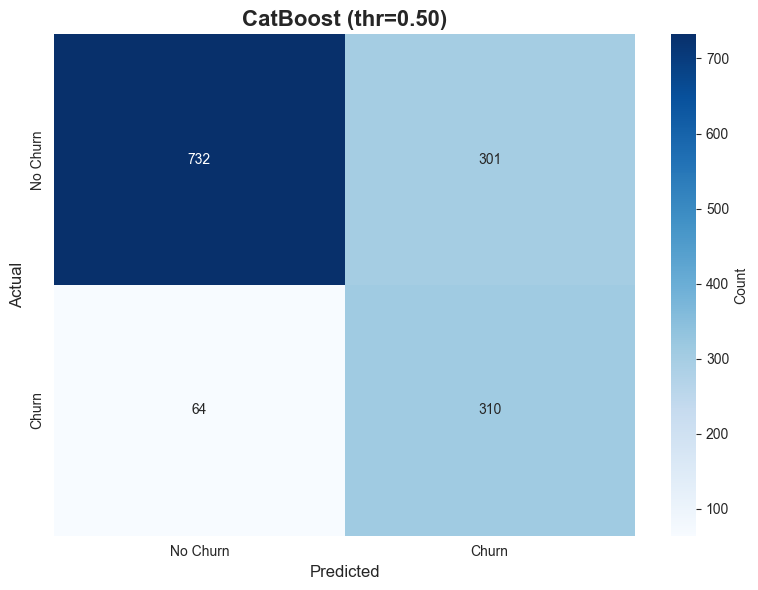

In [31]:
# Work on copies so we don't accidentally modify X_train/X_test used elsewhere
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Identify categorical columns
cat_cols = X_train_cb.select_dtypes(include=["object", "category"]).columns.tolist()

# Make sure tenure_bucket is treated as categorical if present
if "tenure_bucket" in X_train_cb.columns:
    X_train_cb["tenure_bucket"] = X_train_cb["tenure_bucket"].astype("category")
    X_test_cb["tenure_bucket"] = X_test_cb["tenure_bucket"].astype("category")
    if "tenure_bucket" not in cat_cols:
        cat_cols.append("tenure_bucket")

# CatBoost needs categorical feature indices (positions)
cat_feature_indices = [X_train_cb.columns.get_loc(c) for c in cat_cols]

# Handle class imbalance via class weights
class_counts = Counter(y_train)
neg, pos = class_counts[0], class_counts[1]
class_weights = [1.0, neg / pos]  # [weight for class 0 (no churn), weight for class 1 (churn)]

cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    random_seed=RANDOM_STATE,
    od_type="Iter",     # early stopping
    od_wait=50,
    verbose=False,
)

cat_model.fit(
    X_train_cb,
    y_train,
    eval_set=(X_test_cb, y_test),   # if you later create a val set, use (X_val, y_val) here
    cat_features=cat_feature_indices,
    use_best_model=True,
)

# Predict probabilities and labels on the test set
y_proba_cat = cat_model.predict_proba(X_test_cb)[:, 1]
y_pred_cat = (y_proba_cat >= 0.5).astype(int)

print("=== CatBoost (thr=0.50) ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cat))
print(classification_report(y_test, y_pred_cat))
plot_confusion_matrix_pretty(y_test, y_pred_cat, title="CatBoost (thr=0.50)")

## 5. Neural network model (PyTorch MLP)

To experiment with a more flexible model, we also build a small fully-connected neural network (MLP) using PyTorch:

1. Use the same preprocessing pipeline to transform the data.
2. Convert the processed features to PyTorch tensors.
3. Train a simple MLP with:
   - a few hidden layers,
   - ReLU activations,
   - dropout for regularization.

The goal is **not** necessarily to beat tree-based models, but to show how the same features can be used in a deep learning pipeline.


In [32]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
HIDDEN_DIMS = [128, 64]
DROPOUT = 0.3

Using device: cpu


In [33]:
# ==== NEW MLP (ONE-HOT) DATASET ====

# Reload original dataset (clean, no preprocessing pipeline)
df_oh = load_and_clean_churn_data()
df_oh = add_churn_features(df_oh, one_hot=True)  # <-- one-hot version

# Split
X_oh = df_oh.drop(columns=[TARGET_COL])
y_oh = df_oh[TARGET_COL]

X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(
    X_oh,
    y_oh,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_oh
)

print("One-hot train shape:", X_train_oh.shape)
print("One-hot test shape:", X_test_oh.shape)


One-hot train shape: (5625, 39)
One-hot test shape: (1407, 39)


In [34]:
scaler_oh = StandardScaler()
scaler_oh.fit(X_train_oh)

X_train_oh_scaled = scaler_oh.transform(X_train_oh)
X_test_oh_scaled = scaler_oh.transform(X_test_oh)

X_train_oh_scaled.shape, X_test_oh_scaled.shape

((5625, 39), (1407, 39))

In [35]:
preprocessor_torch = build_preprocessor(X_train)

X_train_proc = preprocessor_torch.fit_transform(X_train)
X_test_proc = preprocessor_torch.transform(X_test)

# If the result is sparse, convert to dense
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

X_train_tensor = torch.from_numpy(X_train_proc.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_proc.astype(np.float32))

y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
class ChurnMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=None, dropout=0.0):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [128, 64]

        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # binary output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)  # logits (no sigmoid)

In [37]:
input_dim = X_train_proc.shape[1]
model = ChurnMLP(input_dim, HIDDEN_DIMS, DROPOUT).to(DEVICE)

# Handle class imbalance: pos_weight = (neg / pos)
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_weight, dtype=torch.float32, device=DEVICE)
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_logits, all_targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(yb.cpu())
    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    return total_loss / len(loader.dataset), all_logits.numpy(), all_targets.numpy()

In [38]:
best_val_auc = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_logits, val_targets = eval_epoch(model, val_loader, criterion)

    # compute metrics on the validation set
    val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid
    val_auc = roc_auc_score(val_targets, val_probs)
    val_pred = (val_probs >= 0.5).astype(int)
    val_f1 = f1_score(val_targets, val_pred)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = model.state_dict()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_auc={val_auc:.4f} | "
        f"val_f1={val_f1:.4f}"
    )

# Load best weights
model.load_state_dict(best_state)

Epoch 01 | train_loss=0.9154 | val_loss=0.7859 | val_auc=0.8243 | val_f1=0.6043
Epoch 02 | train_loss=0.7668 | val_loss=0.7526 | val_auc=0.8311 | val_f1=0.6019
Epoch 03 | train_loss=0.7419 | val_loss=0.7408 | val_auc=0.8340 | val_f1=0.6099
Epoch 04 | train_loss=0.7328 | val_loss=0.7342 | val_auc=0.8357 | val_f1=0.6125
Epoch 05 | train_loss=0.7263 | val_loss=0.7345 | val_auc=0.8355 | val_f1=0.6197
Epoch 06 | train_loss=0.7213 | val_loss=0.7321 | val_auc=0.8358 | val_f1=0.6047
Epoch 07 | train_loss=0.7179 | val_loss=0.7326 | val_auc=0.8351 | val_f1=0.6075
Epoch 08 | train_loss=0.7116 | val_loss=0.7319 | val_auc=0.8352 | val_f1=0.6226
Epoch 09 | train_loss=0.7139 | val_loss=0.7317 | val_auc=0.8342 | val_f1=0.6062
Epoch 10 | train_loss=0.7058 | val_loss=0.7367 | val_auc=0.8341 | val_f1=0.6142
Epoch 11 | train_loss=0.7090 | val_loss=0.7339 | val_auc=0.8345 | val_f1=0.6221
Epoch 12 | train_loss=0.7093 | val_loss=0.7342 | val_auc=0.8347 | val_f1=0.6208
Epoch 13 | train_loss=0.6988 | val_loss=

<All keys matched successfully>

In [39]:
from sklearn.metrics import roc_auc_score, classification_report

val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid
val_pred = (val_probs >= 0.5).astype(int)

print("=== PyTorch MLP ===")
print("ROC-AUC:", roc_auc_score(val_targets, val_probs))
print(classification_report(val_targets, val_pred))

=== PyTorch MLP ===
ROC-AUC: 0.8308765290856287
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      1033
         1.0       0.48      0.81      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.75      0.69      1407
weighted avg       0.79      0.71      0.73      1407



## 6. Model comparison

We collect the main metrics for each model:

- ROC-AUC (our primary metric),
- accuracy,
- precision,
- recall,
- F1-score.

This allows us to compare:

- Logistic Regression (tuned),
- Random Forest (tuned),
- HistGradientBoosting (tuned),
- PyTorch MLP.

We will focus on ROC-AUC and the precision/recall trade-offs, because in churn prediction false negatives (missed churners) can be very costly.


In [46]:
def metrics_row(name, y_true, y_pred, y_proba):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

rows = []
rows.append(metrics_row("LogReg (tuned)", y_test, y_pred_lr, y_proba_lr))
rows.append(metrics_row("Random Forest (tuned)", y_test, y_pred_rf, y_proba_rf))
rows.append(metrics_row("HistGradientBoosting (tuned)", y_test, y_pred_hgb, y_proba_hgb))
rows.append(metrics_row("PyTorch MLP", val_targets, val_pred, val_probs))
rows.append(metrics_row("MLP (one-hot, thr=0.50)", y_test_oh, y_pred_mlp_oh, y_proba_mlp_oh))

metrics_df = pd.DataFrame(rows)
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (tuned),0.793177,0.634304,0.524064,0.573939,0.834803
1,Random Forest (tuned),0.759773,0.533210,0.772727,0.631004,0.836832
2,HistGradientBoosting (tuned),0.798863,0.651163,0.524064,0.580741,0.841464
3,PyTorch MLP,0.714996,0.478740,0.812834,0.602577,0.830877
4,"MLP (one-hot, thr=0.50)",0.795309,0.605911,0.657754,0.630769,0.832942


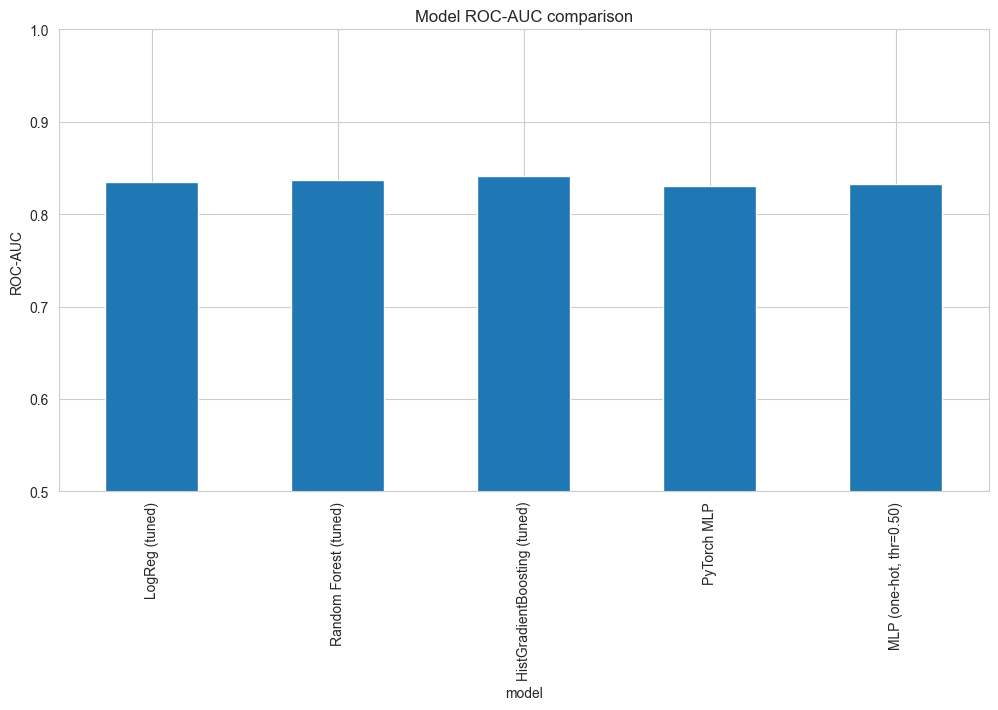

In [43]:
metrics_df.set_index("model")["roc_auc"].plot(kind="bar")
plt.ylim(0.5, 1.0)
plt.ylabel("ROC-AUC")
plt.title("Model ROC-AUC comparison")
plt.show()


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.2, 0.8, 13)
rows = []
for t in thresholds:
    y_pred_t = (y_proba_hgb >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t),
    })

thresh_df = pd.DataFrame(rows)
thresh_df

,threshold,precision,recall,f1
0,0.20,0.454674,0.858289,0.594444
1,0.25,0.481366,0.828877,0.609037
2,0.30,0.515789,0.786096,0.622881
3,0.35,0.548828,0.751337,0.634312
4,0.40,0.591981,0.671123,0.629073
5,0.45,0.624309,0.604278,0.614130
6,0.50,0.651163,0.524064,0.580741
7,0.55,0.675000,0.433155,0.527687
8,0.60,0.681081,0.336898,0.450805
9,0.65,0.726027,0.283422,0.407692


## 7. Threshold tuning for the best model

By default, classifiers predict "churn" when the estimated probability is ≥ 0.5.  
However, in churn prediction, we might prefer to:

- **Catch more churners** (higher recall), even if we get more false positives.
- Or **avoid too many false positives** if contacting customers is expensive.

We therefore:

1. Compute metrics for several probability thresholds.
2. Inspect how precision and recall change.
3. Choose a threshold that balances business needs (here we pick an example value).

This step is crucial to turn a good model into a practical business tool.


In [22]:
BEST_THRESHOLD = 0.35  # example, pick from the table

y_pred_hgb_best = (y_proba_hgb >= BEST_THRESHOLD).astype(int)

In [23]:
print("=== HistGradientBoosting @ threshold", BEST_THRESHOLD, "===")
print("Accuracy:", accuracy_score(y_test, y_pred_hgb_best))
print("Precision:", precision_score(y_test, y_pred_hgb_best))
print("Recall:", recall_score(y_test, y_pred_hgb_best))
print("F1:", f1_score(y_test, y_pred_hgb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb))

=== HistGradientBoosting @ threshold 0.35 ===
Accuracy: 0.7697228144989339
Precision: 0.548828125
Recall: 0.7513368983957219
F1: 0.6343115124153499
ROC-AUC: 0.8414642984713027


In [24]:
def metrics_row(name, y_true, y_pred, y_proba):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

rows = []
rows.append(metrics_row("LogReg (tuned)", y_test, y_pred_lr, y_proba_lr))
rows.append(metrics_row("Random Forest (tuned)", y_test, y_pred_rf, y_proba_rf))
rows.append(metrics_row("HistGradientBoosting (tuned)", y_test, y_pred_hgb_best, y_proba_hgb))
rows.append(metrics_row("PyTorch MLP", val_targets, val_pred, val_probs))

metrics_df = pd.DataFrame(rows)
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (tuned),0.793177,0.634304,0.524064,0.573939,0.834803
1,Random Forest (tuned),0.759773,0.533210,0.772727,0.631004,0.836832
2,HistGradientBoosting (tuned),0.769723,0.548828,0.751337,0.634312,0.841464
3,PyTorch MLP,0.732054,0.497427,0.775401,0.606061,0.831596


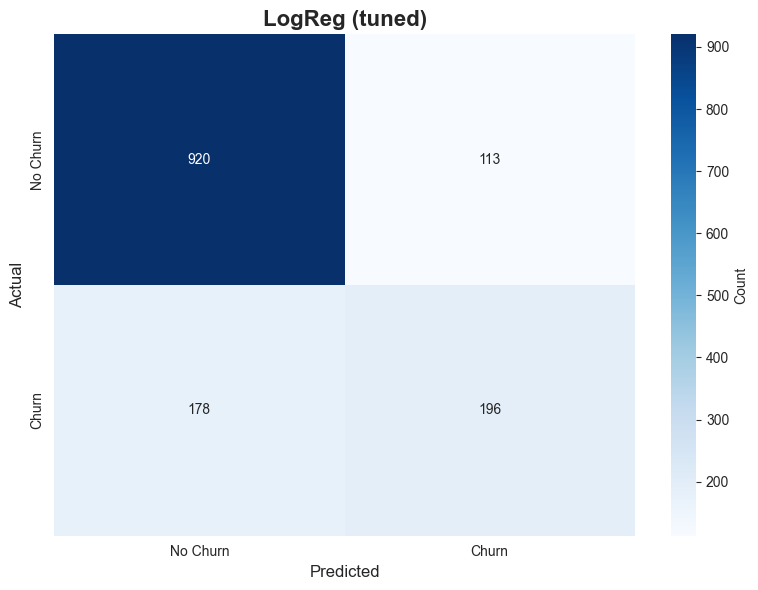

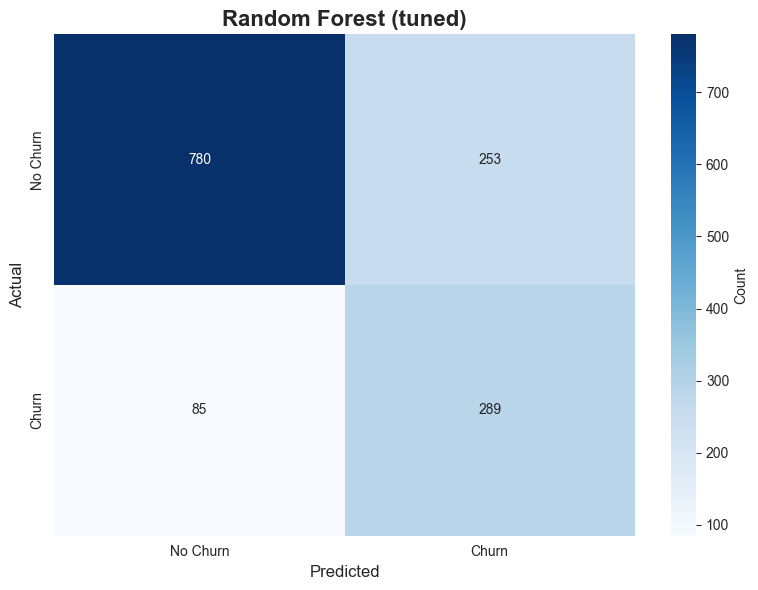

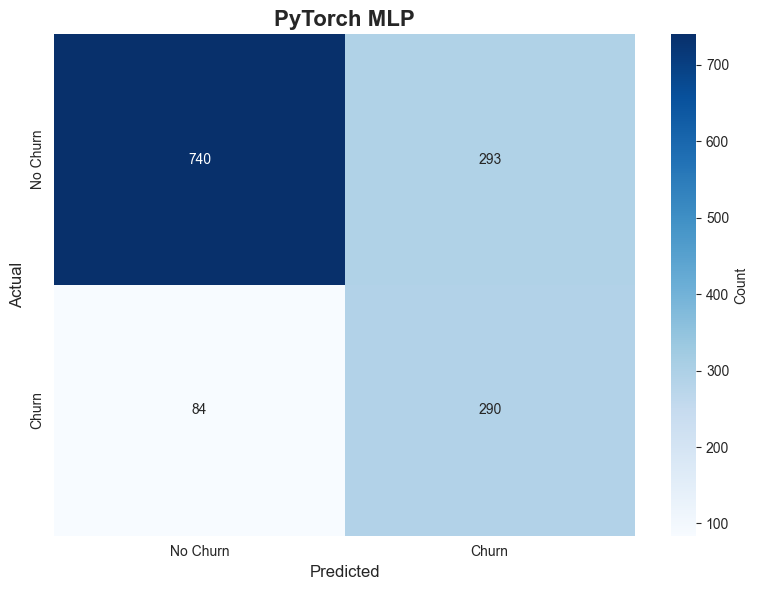

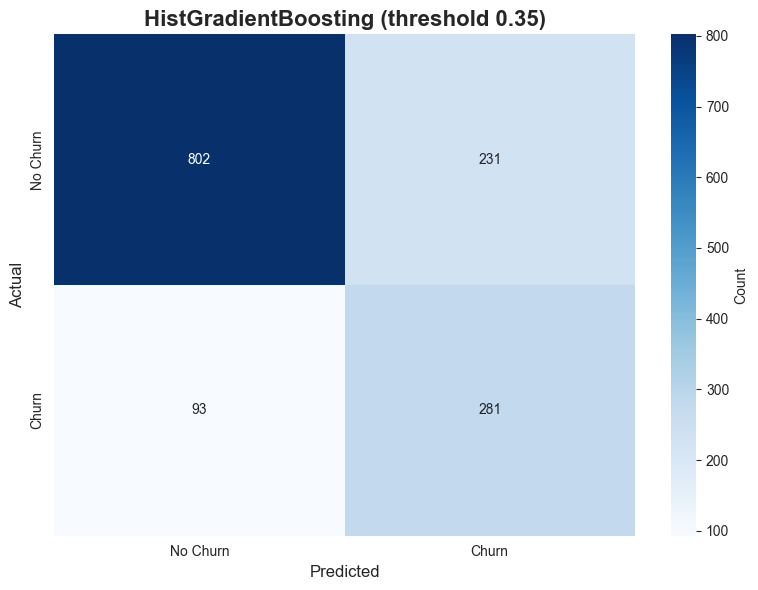

In [25]:
plot_confusion_matrix_pretty(y_test, y_pred_lr, title="LogReg (tuned)")
plot_confusion_matrix_pretty(y_test, y_pred_rf, title="Random Forest (tuned)")
plot_confusion_matrix_pretty(val_targets, val_pred, title="PyTorch MLP")
plot_confusion_matrix_pretty(
    y_test,
    y_pred_hgb_best,
    title=f"HistGradientBoosting (threshold {BEST_THRESHOLD:.2f})"
)

In [26]:
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_proc, dtype=torch.float32)).squeeze(-1)
    y_proba_mlp = torch.sigmoid(logits).cpu().numpy()

thresholds = np.linspace(0.2, 0.8, 61)  # finer grid than before
rows = []
for t in thresholds:
    y_pred_t = (y_proba_mlp >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t),
    })

thresh_mlp_df = pd.DataFrame(rows)
thresh_mlp_df.head()

,threshold,precision,recall,f1
0,0.20,0.386289,0.949198,0.549111
1,0.21,0.389682,0.949198,0.552529
2,0.22,0.394649,0.946524,0.557042
3,0.23,0.397523,0.943850,0.559429
4,0.24,0.403913,0.938503,0.564763


In [27]:
best_mlp_row = thresh_mlp_df.loc[thresh_mlp_df["f1"].idxmax()]
BEST_MLP_THRESHOLD = best_mlp_row["threshold"]
best_mlp_row

threshold    0.620000
precision    0.583710
recall       0.689840
f1           0.632353
Name: 42, dtype: float64

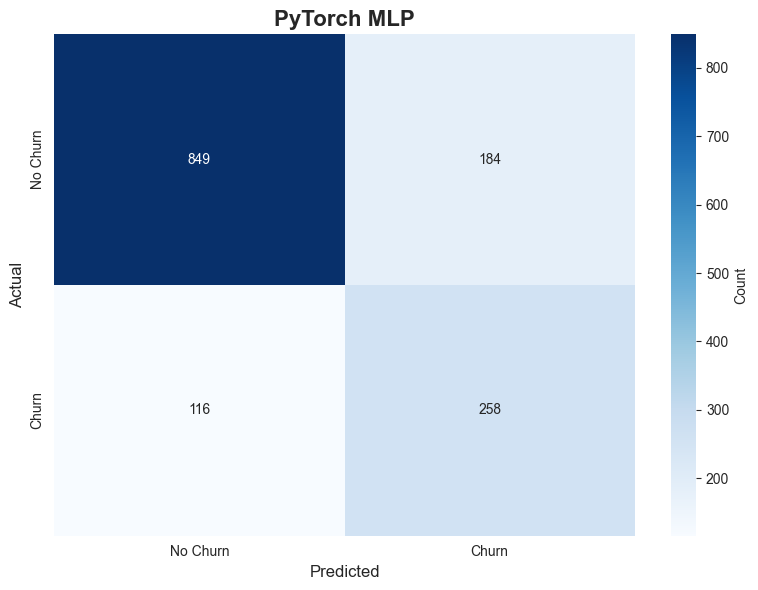

In [28]:
y_test_pred_mlp = (y_proba_mlp >= BEST_MLP_THRESHOLD).astype(int)




plot_confusion_matrix_pretty(y_test, y_test_pred_mlp, title="PyTorch MLP")

## 8. Conclusions

In this project, we developed and compared several machine-learning models to
predict customer churn for a telecommunications company. The goal was to build
a model that can identify customers at risk of leaving, allowing the business to
take proactive actions such as offering promotions, improving support, or
targeting retention campaigns.

### Key Findings

- **Gradient-boosted trees (HistGradientBoostingClassifier)** consistently provided
  the best overall balance between **ROC-AUC**, **precision**, **recall**, and **F1 score**.
  After threshold tuning, the model achieved strong recall without exploding the
  number of false positives. This makes it an excellent general-purpose churn
  prediction model.

- **Logistic Regression** performed better than expected on ROC-AUC thanks to
  strong one-hot encoding and balanced class weights. It is simple,
  interpretable, and useful as a baseline, but less powerful than the boosting models.

- **Random Forest** performed reasonably well but did not match the boosted
  models in recall or F1. Ensemble bagging methods tend to be more affected by
  sparse one-hot encoded features and thus were less competitive here.

- **PyTorch MLP** showed promise as a high-recall model when threshold-tuned.
  Neural networks can capture nonlinear patterns well, but require careful
  scaling and regularization. In this case, the MLP slightly underperformed
  gradient boosting but can be useful when recall is more important than
  precision.

### Business Interpretation

For a telecom provider, the relative importance of precision vs. recall depends
on economic trade-offs:

- **High Recall Scenario** – Preferred when losing a customer is expensive and
  contacting a non-churner is cheap. In this case, the tuned MLP or a
  low-threshold boosted model is ideal.

- **Balanced Scenario** – When both false positives and missed churners matter,
  **HistGradientBoosting** is the clear winner. It captures complex churn
  patterns, handles the class imbalance well, and provides stable predictions.

Overall, **HistGradientBoosting with a tuned decision threshold** is recommended
as the final production model for this project, with the MLP serving as a strong
alternative for high-recall use cases.

### Next Steps

Future improvements could include:

- Calibrating predicted probabilities (e.g., isotonic regression)
- Using SHAP or permutation importance for interpretability
- Running a cost-benefit analysis to select an optimal business threshold
- Deploying the model as an API or batch-scoring service

This concludes the model training and evaluation process for the Telco churn project.
